# **NLP Standard Project**
## **Emotion Discovery and Reasoning its Flip in Conversation (EDiReF) - SemEval 2024 – Task 10 - Task C – EFR in English conversation:**
### Given a multiparty code-mixed conversation along with emotions for each utterance, the goal is to identify the trigger utterance for each emotionflip in the dialogue

In [34]:
# Some useful imports
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
import itertools

# For BERT-baesd models
import torch
import transformers
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import cuda

# For metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [35]:
# Set the device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


# *DATA LOADING*

## Dataframe structure
Loading the JSON into a Pandas Dataframe and taking a first look to its structure:

In [36]:
# Load the JSON file and read it into a DataFrame
#file_path_train = '/kaggle/input/dataset/MELD_train_efr.json'
#file_path_train = '/kaggle/input/meld-train-efr/MELD_train_efr.json'
file_path_train = './Data/Task C/MELD_train_efr.json'
df = pd.read_json(file_path_train)

# Store a copy of the original DataFrame
original_df = df.copy()

df.shape

(4000, 5)

Each row represents an utterance in a conversation, with the corresponding speakers involved, the associated emotions, the text of the utterances, and numerical values indicating the presence of triggers for specific emotions.

In [37]:
# Take a look to data structure
df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


# *PRE-PROCESSING*

## NaN values:
 Some trigger labels are not correctly formatted and appear as NaN values, so we convert them to 0 values to avoid errors.

In [38]:
# Count the number of NaN values
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 9


In [39]:
# Convert NaN values to 0
df["triggers"] = df["triggers"].apply(lambda x: [0 if elem != 1 and elem != 0 else elem for elem in x])

In [40]:
# Verify that all NaN values have been converted
count = sum(elem != 1 and elem != 0 for row in df["triggers"] for elem in row)
print(f"Number of NaN values: {count}")

Number of NaN values: 0


## Data Splitting
Here we split the DataFrame into training, test and validation sets using an 80/10/10 split as said in the project description. We then print the shape of each set.

In [41]:
# Split the DataFrame into training, validtion and test set
df_train, temp = train_test_split(df, test_size=0.2, shuffle=False)
df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

# Print the shape of each set
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3200, 5)
Test shape: (400, 5)
Val shape: (400, 5)


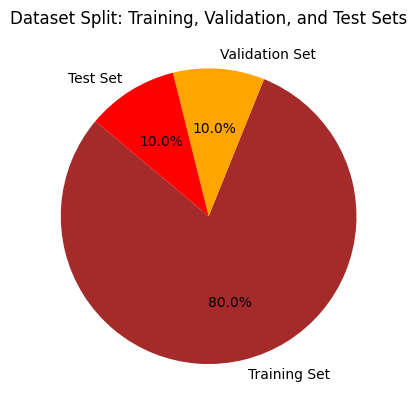

In [42]:
sizes = [len(df_train), len(df_val), len(df_test)]
labels = ['Training Set', 'Validation Set', 'Test Set']
colors = ['brown', 'orange', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split: Training, Validation, and Test Sets')
plt.show()

We noticed that a single dialogue appears at the end of the training set and the beginning of the test set. To avoid this overlap and ensure the dialogue is contained within only one set, we decided to adjust the data split slightly.

In [43]:
print(f"Dialogue in the last row of df_train: {df_train['utterances'][3199]}")

Dialogue in the last row of df_train: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.']


In [44]:
print(f"Dialogue in the first row of df_test: {df_test['utterances'][3200]}")

Dialogue in the first row of df_test: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!"]


In [45]:
print(f"The dialogue continues until utterance 3205:")
print(f"Dialogue: {df_test['utterances'][3205]}")

The dialogue continues until utterance 3205:
Dialogue: ["Dr. Geller, there's a seat over here.", "Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.", "I'm having lunch right here, with my good friend Joey, if he'll sit with me.", 'I will sit with you Dr. Geller.', "Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.", "Now, I look around this cafeteria, and y'know what I see, I see-I see division.", 'Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"', 'Now, I say we shed these-these coats that separate us, and we get to know the people underneath.', "I'm Ross!", "I'm divorced, and I have a kid!", "I'm Joey! I'm an actor! I don't know squat about dinosaurs!", "I'm Ted, and I just moved here a month ago, and New York really scares me.", 'All right, there you go!', 'Yeah, you hang in there Teddy!', "I'm Andrew, and I didn't pay for this pear.", 

In [46]:
print(f"Dialogue in the last row of df_test: {df_test['utterances'][3599]}")

Dialogue in the last row of df_test: ['Oh, that is so unfortunate.', 'What?', 'Cute naked guy is really starting to put on weight.', "Okay, I'll be back in just a minute. Oh, Phoebe I'm sorry that I left lipstick marks on the phone.", "You didn't leave lipstick marks on the phone.", "Oh, then it must've been you. Bye.", "Bye-bye!  That's why I moved out.", "Hey, y'know while we're on that, when are you gonna tell my sister that you don't live here anymore.", 'I think on some levels she already knows.']


In [47]:
print(f"Dialogue in the first row of df_val: {df_val['utterances'][3600]}")

Dialogue in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?']


In [48]:
# Reshape the sets to take into account this observation
df_train = df.iloc[:3205,:]
temp = df.iloc[3205:,:]

df_test, df_val = train_test_split(temp, test_size=0.5, shuffle=False)

# Print the new shape of the three sets
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (397, 5)
Val shape: (398, 5)


We make a similar observation printing the last utterance of validation set and the first one of test set:

In [49]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3601]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.']


In [50]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3602]}")

Dialouge in the first row of df_val: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


**Reshape of the sets**

In [51]:
# Reshape the sets in a similar way as before
df_train = df.iloc[:3205,:]
df_test = df.iloc[3205:3603,:]
df_val = df.iloc[3603:,:]

In [52]:
print(f"Dialouge in the last row of df_test: {df_test['utterances'][3602]}")

Dialouge in the last row of df_test: ['Night Mon. Night Julio.', 'Adiós.', 'Look Julio, someone left their book here.', 'Ah actually, that is mine.', 'Oh yeah, what are you reading?', 'Flowers of Evil, by Beaudalire. Have you read it?', 'Have I read it?  No, are you enjoying it?', "I thought I would, but the translation's no good.", "Your a poet and don't know it.", 'Actually I ah, I am a poet.', 'Oh, then you do know it.  So um what kind of things do you write about?', 'Things that move me. The, the shadow of a tree, a child laughing, or this lip.', 'Mine?  Right here?', 'I can write an epic poem about this lip.', "How would that go?  Well, it didn't rhyme, but I liked it."]


In [53]:
print(f"Dialouge in the first row of df_val: {df_val['utterances'][3603]}")

Dialouge in the first row of df_val: ['Last stop, Montreal. This stop is Montreal.', 'What?', 'I made a bet with myself that you have beautiful eyes. Now that I see them, I win.', 'What?', "We're at my stop. But would you like to have coffee?", 'Are we really in Montreal?!', 'Yes we are. So, coffee?', 'Coffee sounds great.  Wait, so, so you live in Montreal?']


**The final shape of data is the following:**

In [54]:
# Print the final shape of the sets
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Val shape: {df_val.shape}")

Train shape: (3205, 5)
Test shape: (398, 5)
Val shape: (397, 5)


Here we can see the real dimensions of the sets. We have opted to maintain this division because the dimensions of the sets are quite similar. Additionally, keeping the same dialogues together in the same sets ensures consistency and coherence.

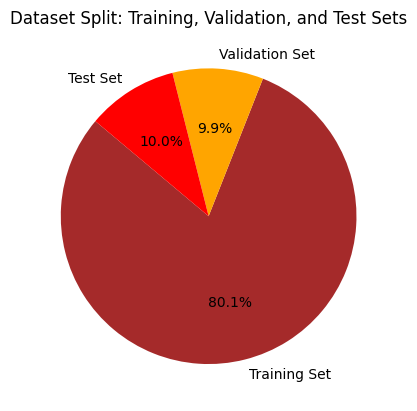

In [55]:
sizes = [len(df_train), len(df_val), len(df_test)]
labels = ['Training Set', 'Validation Set', 'Test Set']
colors = ['brown', 'orange', 'red']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split: Training, Validation, and Test Sets')
plt.show()

## Dialogues splitting
This function separates each sentence in the DataFrame's 'utterances' into individual rows. It collects corresponding speaker, emotion, and trigger information, and then constructs a new DataFrame with this split data.

In [56]:
# Define the splitting function
def split_utterances(df):
    
    '''
    Split the utterances into a list of strings
    params: df: DataFrame
    return: df: DataFrame
    '''

    # Initiate some useful lists before iteration
    speakers_list = []
    utterances_list = []
    emotions_list = []
    trigger_list = []

    # Iterate over each row of the original DataFrame
    for index, row in df.iterrows():
        speakers = row['speakers']
        utterances = row['utterances']
        emotions = row['emotions']
        triggers = row['triggers']

        # Iterate over each utterance in 'utterances' array
        for i in range(len(utterances)):
            speakers_list.append(speakers[i])
            utterances_list.append(utterances[i])
            emotions_list.append(emotions[i])
            trigger_list.append(triggers[i])

    # Convert the lists into a new DataFrame
    new_df = pd.DataFrame({
        'speaker': speakers_list,
        'utterance': utterances_list,
        'emotion': emotions_list,
        'trigger': trigger_list
    })

    return new_df

In [57]:
# Split into sentences the training set
df_train_s = split_utterances(df_train)
df_train_s.head(15)

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0
5,Chandler,also I was the point person on my company's tr...,neutral,0.0
6,The Interviewer,You must've had your hands full.,neutral,0.0
7,Chandler,That I did. That I did.,neutral,0.0
8,The Interviewer,So let's talk a little bit about your duties.,neutral,0.0
9,Chandler,My duties? All right.,surprise,0.0


In [58]:
# Take a look to the new structure of the training set
print(df_train_s.iloc[52:69,:])

     speaker                                          utterance   emotion  \
52  Chandler                                          Hey, Mon.   neutral   
53    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
54  Chandler                                         Do I ever.       joy   
55  Chandler                                          Hey, Mon.   neutral   
56    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
57  Chandler                                         Do I ever.       joy   
58    Monica           Chris says they're closing down the bar.   sadness   
59  Chandler                                          Hey, Mon.   neutral   
60    Monica  Hey-hey-hey. You wanna hear something that sucks.   neutral   
61  Chandler                                         Do I ever.       joy   
62    Monica           Chris says they're closing down the bar.   sadness   
63  Chandler                                            No way!  surprise   

In [59]:
# Split into sentences of the remaining sets
df_test_s = split_utterances(df_test)
df_val_s = split_utterances(df_val)

## *DATA EXPLORATION*
### Balance of the dataset
To determine if the train dataset is unbalanced, we have analyzed the distribution of **'emotions'** and **'triggers'** labels. Specifically, we checked if certain labels are disproportionately represented compared to others by calculating the frequency of each label in the dataset and comparing these frequencies to identify any significant imbalances.

### Emotions distribution:

In [71]:
def count_emotions_distribution(df, column_name='emotions'):
    """
    Count the distribution of 'emotions' values in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the emotions data.
    column_name (str): The name of the column containing the emotions.

    Returns:
    dict: A dictionary with emotions as keys and their counts as values.
    """
    emotions_counts = {}
    for emotions in df[column_name]:
        for emotion in emotions:
            if emotion in emotions_counts:
                emotions_counts[emotion] += 1
            else:
                emotions_counts[emotion] = 1
    return emotions_counts


emotions_counts_train = count_emotions_distribution(df_train)
emotions_counts_test = count_emotions_distribution(df_test)
emotions_counts_val = count_emotions_distribution(df_val)
print(f"Emotion Counts in Train set: {emotions_counts_train}")
print(f"Emotion Counts in Test set: {emotions_counts_test}")
print(f"Emotion Counts in Val set: {emotions_counts_val}")



Emotion Counts in Train set: {'neutral': 12264, 'surprise': 3777, 'fear': 922, 'sadness': 1934, 'joy': 5141, 'disgust': 816, 'anger': 3031}
Emotion Counts in Test set: {'neutral': 1505, 'sadness': 349, 'fear': 121, 'joy': 576, 'anger': 455, 'surprise': 439, 'disgust': 88}
Emotion Counts in Val set: {'neutral': 1494, 'surprise': 429, 'anger': 478, 'disgust': 145, 'sadness': 365, 'joy': 600, 'fear': 71}


In [72]:
def get_emotions_and_counts(emotions_counts):
    """
    Extracts the keys and values from the emotions_counts dictionary.

    Parameters:
    emotions_counts (dict): A dictionary with emotions as keys and their counts as values.

    Returns:
    tuple: A tuple containing two lists - emotions and their corresponding counts.
    """
    emotions = list(emotions_counts.keys())
    emotion_counts = list(emotions_counts.values())
    return emotions, emotion_counts

emotions_train, emotion_count_train = get_emotions_and_counts(emotions_counts_train)
emotions_test, emotion_count_test = get_emotions_and_counts(emotions_counts_test)
emotions_val, emotion_count_val = get_emotions_and_counts(emotions_counts_val)


In [96]:
emotions = list(set(emotions_counts_train.keys()).union(set(emotions_counts_test.keys())).union(set(emotions_counts_val.keys())))
colors = plt.cm.Paired.colors[:len(emotions)]
color_map = {emotion: colors[i] for i, emotion in enumerate(emotions)}

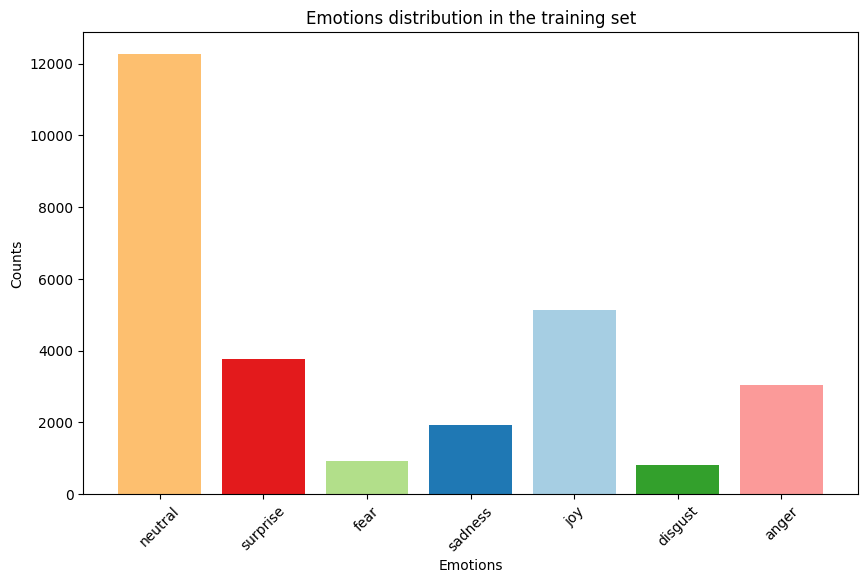

In [97]:
# Convert the dictionary of counts into two lists
#use different colors

emotions_train = list(emotions_counts_train.keys())
emotion_count_train = list(emotions_counts_train.values())

# Use the same color map defined earlier
colors = [color_map[emotion] for emotion in emotions_train]

# Plotting a histogram for the counts in the training set
plt.figure(figsize=(10, 6))
# Create a bar plot for the training set emotions
plt.bar(emotions_train, emotion_count_train, color=colors, label='Train Set')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotions distribution in the training set')
plt.xticks(rotation=45)
plt.show()

This histogram shows the distribution of different emotions in the training set, the plot reveals that the dataset is unbalanced, **'neutral'** emotion tag has a significant higher count than the others. \
An unbalanced dataset can lead to many problems, like a biased model training. To address this issue we will use weighted loss functions to balance the dataset.

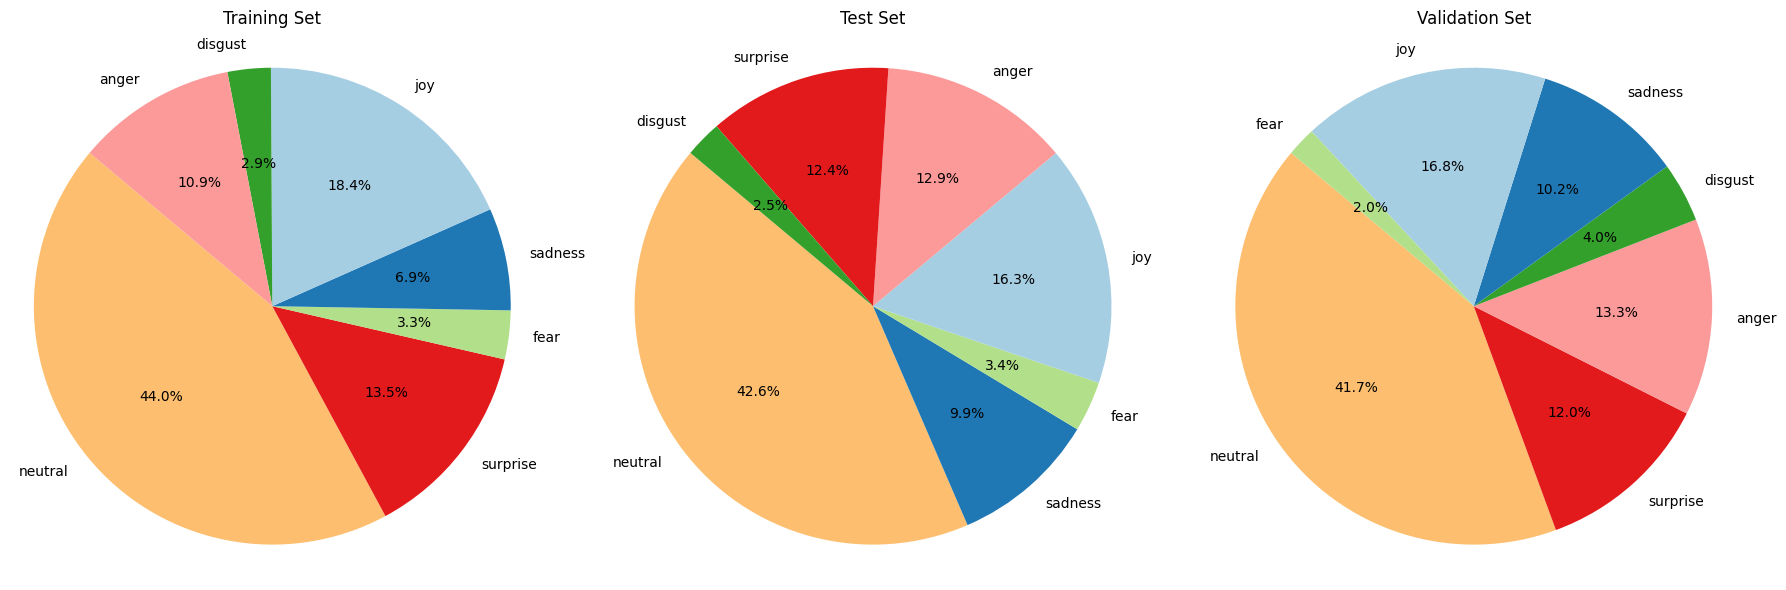

In [98]:
import matplotlib.pyplot as plt

def plot_emotions_distribution(ax, emotions_counts, title):
    # Extract keys and values from the dictionary
    emotions = list(emotions_counts.keys())
    counts = list(emotions_counts.values())
    colors = [color_map[emotion] for emotion in emotions]

    # Create a pie chart
    ax.pie(counts, labels=emotions, autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(title)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for training set
plot_emotions_distribution(axs[0], emotions_counts_train, 'Training Set')

# Plot for test set
plot_emotions_distribution(axs[1], emotions_counts_test, 'Test Set')

# Plot for validation set
plot_emotions_distribution(axs[2], emotions_counts_val, 'Validation Set')

# Adjust layout
plt.tight_layout()
plt.show()

These plots help us understanding how the emotions are distributed across different sets. As we can see, the distributions on the validation set is similar to the training one, this is crucial because it ensures that the model is validated on representative sample. \
The predominance of the neutral tag indicates that the dataset remains imbalanced even in the test and validation sets, highlighting the importance of using a weighted approach.

### Triggers distribution:

In [99]:
# Count the distribution of 'triggers' values
triggers_counts= {}
for triggers in df_train['triggers']:
    for trigger in triggers:
        if trigger in triggers_counts:
            triggers_counts[trigger] += 1
        else:
            triggers_counts[trigger] = 1
            
# Print such counts
print(triggers_counts)

{0.0: 23586, 1.0: 4299}


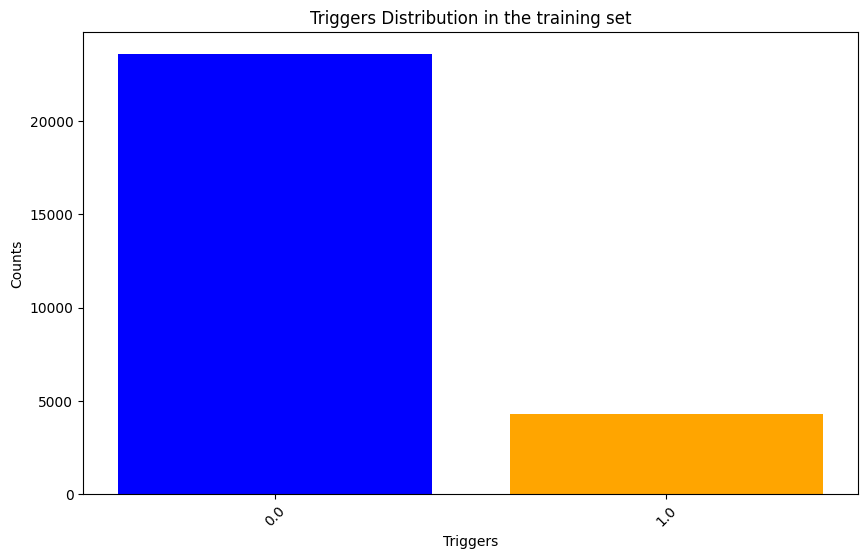

In [101]:
# Convert the dictionary of counts into two lists
trigger = list(triggers_counts.keys())
trigger_counts = list(triggers_counts.values())

# Plot a histogram for such counts
plt.figure(figsize=(10, 6))
plt.bar(trigger, trigger_counts, color=['blue', 'orange'])
plt.xlabel('Triggers')
plt.ylabel('Counts')
plt.title('Triggers Distribution in the training set')
plt.xticks(ticks=trigger, labels=['0.0', '1.0'], rotation=45)
plt.show()

The weight for each class (emotion) is calculated using the formula:  
$$\text{weight} = \frac{\text{total samples}}{\text{number of emotions}\times\text{count}}$$
This formula ensures that classes with fewer samples get higher weights, and classes with more samples get lower weights.

By assigning higher weights to underrepresented classes, the model is encouraged to pay more attention to these classes, thereby improving its performance on them.

In [102]:
# Calculate classes' weights
total_samples = len(df_train)
class_weights = {emotion: total_samples / (len(emotions_counts_train) * count) for emotion, count in emotions_counts_train.items()}

# Print such weights
print("Class weights:", class_weights)

Class weights: {'neutral': 0.03733342652129345, 'surprise': 0.12122243655206325, 'fear': 0.4965912612333437, 'sadness': 0.23674102526222485, 'joy': 0.08905993831105677, 'disgust': 0.5610994397759104, 'anger': 0.1510581137766885}


https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

In [104]:
all_emotions = [label for sublist in df_train['emotions'] for label in sublist]
train_emotions = np.array(all_emotions)
unique_emotions = np.unique(all_emotions)

# Calculate weights
emotion_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_emotions, y=train_emotions)

# Save the weights in a dictionary 
emotions_weights_dict = dict(zip(unique_emotions, emotion_weights))

print("Emotion class weights:", emotions_weights_dict)

Emotion class weights: {'anger': 1.3142762878823584, 'disgust': 4.881827731092437, 'fear': 4.320576386736907, 'joy': 0.7748631450245922, 'neutral': 0.3248182834777747, 'sadness': 2.059757719013148, 'surprise': 1.0546919323726314}


### Class weights computing using sklearn class_weight='balanced'

In [106]:
# Calculate triggers' weights
all_triggers = [label for sublist in df_train['triggers'] for label in sublist]
train_triggers = np.array(all_triggers)
unique_triggers = np.unique(all_triggers)

trigger_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_triggers, y=train_triggers)
triggers_weights_dict = dict(zip(unique_triggers, trigger_weights))

print("Trigger class weights:", triggers_weights_dict)

Trigger class weights: {0.0: 0.5911345713558891, 1.0: 3.243196092114445}


## *MODELS DEFINITION*

As per the requirements, we will train and evaluate a **BERT baseline** under two different configurations:
1. **Frozen**: In this setup, we freeze the weights of the BERT embedding layer and only fine-tune the classifier heads on top.

2. **Full Fine-tuning**: In this approach, we fine-tune the entire BERT model architecture, including both the embedding layers and classifier heads.


Additionally, we will evaluate two baseline classifiers for both emotions and triggers:

1. A **random classifier**, which predicts randomly.
   
2. A **majority classifier**, which always predicts the most frequent class.

### Baseline models
#### Defining random and majority dummy classifiers
These lines of code define two types of baseline classifiers using the **DummyClassifier** from the **sklearn** library, both for emotions and triggers. These classifiers are used for comparison to evaluate how a simple, non-learned model would perform on the task

In [108]:
# Defining classifiers for emotions
random_emotions = DummyClassifier(strategy='uniform', random_state = 42)
majority_emotions = DummyClassifier(strategy='most_frequent')
# Defining classifiers for triggers
random_triggers = DummyClassifier(strategy='uniform', random_state = 42)
majority_triggers = DummyClassifier(strategy='most_frequent')

In [109]:
# Look again at the structure of the DataFrame
df_train_s.head()

,speaker,utterance,emotion,trigger
0,Chandler,also I was the point person on my company's tr...,neutral,0.0
1,The Interviewer,You must've had your hands full.,neutral,0.0
2,Chandler,That I did. That I did.,neutral,0.0
3,The Interviewer,So let's talk a little bit about your duties.,neutral,1.0
4,Chandler,My duties? All right.,surprise,0.0


In [110]:
# Isolate labels for training set
X_train = df_train_s.drop(columns=['emotion', 'trigger'])

y_train_emotions = df_train_s['emotion']
y_train_triggers = df_train_s['trigger']

In [111]:
# Isolate labels for test set
X_test = df_test_s.drop(columns=['emotion', 'trigger'])

y_test_emotions = df_test_s['emotion']
y_test_triggers = df_test_s['trigger']

In [112]:
# Fit the emotions' dummy classifiers
random_emotions.fit(X_train, y_train_emotions)
majority_emotions.fit(X_train, y_train_emotions)

# Fit the triggers' dummy classifiers
random_triggers.fit(X_train, y_train_triggers)
majority_triggers.fit(X_train, y_train_triggers)

DummyClassifier(strategy='most_frequent')

#### **Evaluating baseline models**

In this part, we evaluates the performance of the DummyClassifier on the test set by making predictions.

`y_pred_random_emotions` and `y_pred_majority_emotions` store the predicted emotion labels using the random and majority classifiers, respectively.

Similarly, `y_pred_random_triggers` and `y_pred_majority_triggers` store the predicted trigger labels using the random and majority classifiers for triggers.

These predictions will later be compared with the actual labels to assess the models' performance.

In [113]:
# Evaluate emotions' dummy classifiers on test set
y_pred_random_emotions = random_emotions.predict(X_test)
y_pred_majority_emotions = majority_emotions.predict(X_test)

# Evaluate triggers' dummy classifiers on test set
y_pred_random_triggers = random_triggers.predict(X_test)
y_pred_majority_triggers = majority_triggers.predict(X_test)

In [114]:
# Print classification reports
# For emotions
print("Classification report for baseline random clf emotions:")
report_random_emotions = classification_report(y_test_emotions, y_pred_random_emotions, zero_division=0, output_dict=True)
df_random_emotions = pd.DataFrame(report_random_emotions).transpose()
print(df_random_emotions)

print("\nClassification report for baseline majority clf emotions:")
report_majority_emotions = classification_report(y_test_emotions, y_pred_majority_emotions, zero_division=0, output_dict=True)
df_majority_emotions = pd.DataFrame(report_majority_emotions).transpose()
print(df_majority_emotions)

# For triggers
print("\nClassification report for baseline random clf triggers:")
report_random_triggers = classification_report(y_test_triggers, y_pred_random_triggers, zero_division=0, output_dict=True)
df_random_triggers = pd.DataFrame(report_random_triggers).transpose()
print(df_random_triggers)

print("\nClassification report for baseline majority clf triggers:")
report_majority_triggers = classification_report(y_test_triggers, y_pred_majority_triggers, zero_division=0, output_dict=True)
df_majority_triggers = pd.DataFrame(report_majority_triggers).transpose()
print(df_majority_triggers)

Classification report for baseline random clf emotions:
              precision    recall  f1-score      support
anger          0.145914  0.164835  0.154799   455.000000
disgust        0.029644  0.170455  0.050505    88.000000
fear           0.029787  0.115702  0.047377   121.000000
joy            0.159615  0.144097  0.151460   576.000000
neutral        0.387405  0.134884  0.200099  1505.000000
sadness        0.096457  0.140401  0.114352   349.000000
surprise       0.124236  0.138952  0.131183   439.000000
accuracy       0.141523  0.141523  0.141523     0.141523
macro avg      0.139008  0.144189  0.121396  3533.000000
weighted avg   0.236567  0.141523  0.160345  3533.000000

Classification report for baseline majority clf emotions:
              precision    recall  f1-score      support
anger          0.000000  0.000000  0.000000   455.000000
disgust        0.000000  0.000000  0.000000    88.000000
fear           0.000000  0.000000  0.000000   121.000000
joy            0.000000  0.000

#### **Emotion classifiers:**
Both **random** and **majority** classifiers perform poorly, with the majority classifier showing better accuracy due to the prevalence of the **'neural'** tag.
The imbalance in the dataset (with a large "neutral" class) affects the performance of both classifiers.
#### **Trigger classifiers:**
The random classifier for triggers has a reasonable F1-score for the majority class but struggles with the minority class. \
The majority classifier for triggers has a high accuracy, but this is misleading since it always predicts the majority class and ignores the minority one, leading to poor performance for class "1.0."


#### These results emphasize the importance of evaluating models beyond accuracy and using more advanced techniques to handle class imbalance

### BERT-based models

#### One-Hot-Encoding

In this section, we define the dictionaries that encodes each emotion and trigger as a one-hot vector, where only one position is set to 1, corresponding to the specific emotion (or trigger), while all others are 0.

In [115]:
# Define an encoding dictionary for emotions label
emotions_encoded_dict = {
    "neutral": [1, 0, 0, 0, 0, 0, 0],
    "joy": [0, 1, 0, 0, 0, 0, 0],
    "surprise": [0, 0, 1, 0, 0, 0, 0],
    "sadness": [0, 0, 0, 1, 0, 0, 0],
    "anger": [0, 0, 0, 0, 1, 0, 0],
    "disgust": [0, 0, 0, 0, 0, 1, 0],
    "fear": [0, 0, 0, 0, 0, 0, 1]
}

In [116]:
# Define an encoding dictionary for triggers label
triggers_encoded_dict = {
    0: [1, 0],
    1: [0, 1]
}

#### Data exploration
By exploring the data, we can analyze the distribution of dialogues lengths and set the max_length to capture the majority of dialugues while avoiding unnecessary padding or truncation. 

This ensures that the model can effectively handle most inputs without cutting off important information or increasing computational cost by including too many padding token.

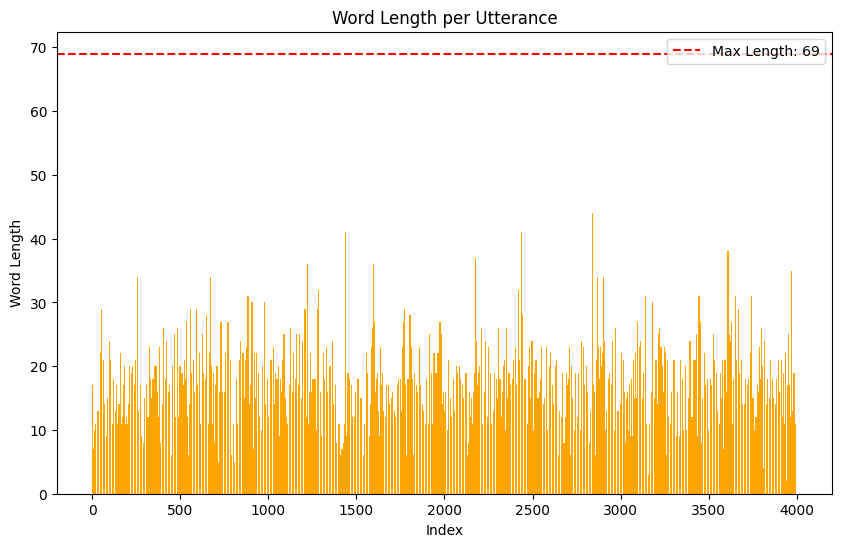

In [120]:
# Calculate the length of every word for every row in 'utterances'
df_length = pd.DataFrame()
df_length['word_length'] = df['utterances'].apply(lambda arr: max(len(x.split()) for x in arr))


# Calculate the maximum length over all rows
max_length = df_length['word_length'].max()


# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_length.index, df_length['word_length'], color='orange')
plt.axhline(y=max_length, color='r', linestyle='--', label=f'Max Length: {max_length}')
plt.xlabel('Index')
plt.ylabel('Word Length')
plt.title('Word Length per Utterance')
plt.legend()
plt.show()

max length: 263
max length id: 3901


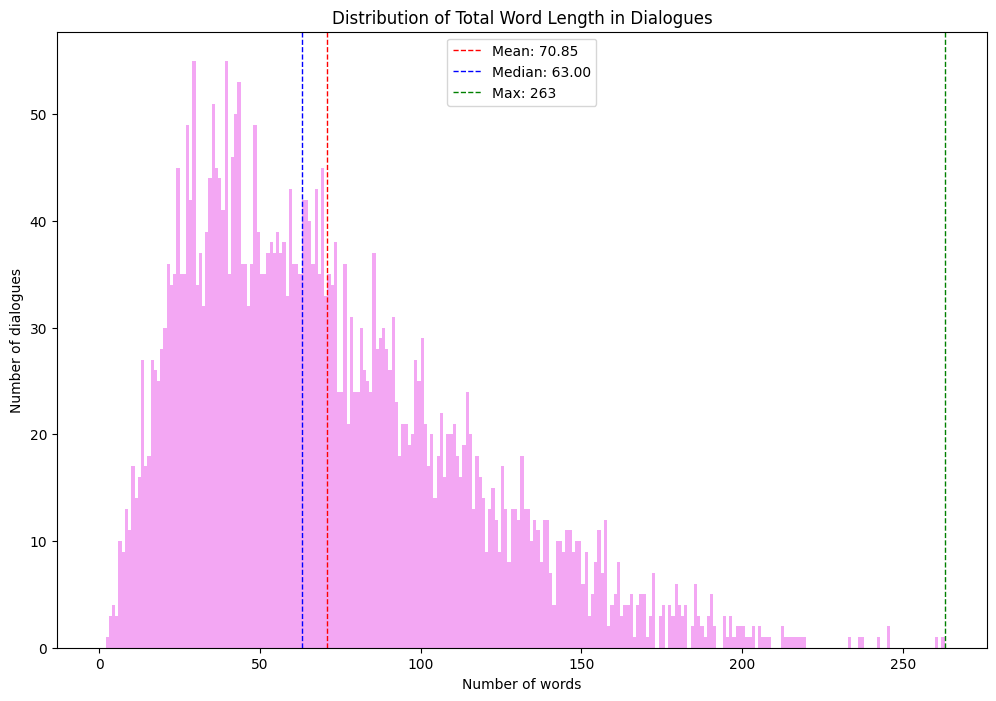

In [126]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the length of each word for every row in 'utterances' column
df_length = pd.DataFrame()
df_length['total_word_length'] = df['utterances'].apply(lambda arr: sum(len(x.split()) for x in arr))

# Calculate the maximum length over all the rows
max_length = df_length['total_word_length'].max()
print(f"max length: {max_length}")

# Get the id of the longest dialogue
max_length_id = df_length['total_word_length'].idxmax()
print(f"max length id: {max_length_id}")

# Calculate mean and median
mean_length = df_length['total_word_length'].mean()
median_length = df_length['total_word_length'].median()

# Plot a histogram
plt.figure(figsize=(12, 8))
plt.hist(df_length['total_word_length'], bins=range(0, df_length['total_word_length'].max() + 1, 1), color='violet', alpha=0.7)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.axvline(max_length, color='green', linestyle='dashed', linewidth=1, label=f'Max: {max_length}')
plt.xlabel('Number of words')
plt.ylabel('Number of dialogues')
plt.title('Distribution of Total Word Length in Dialogues')
plt.legend()
plt.show()


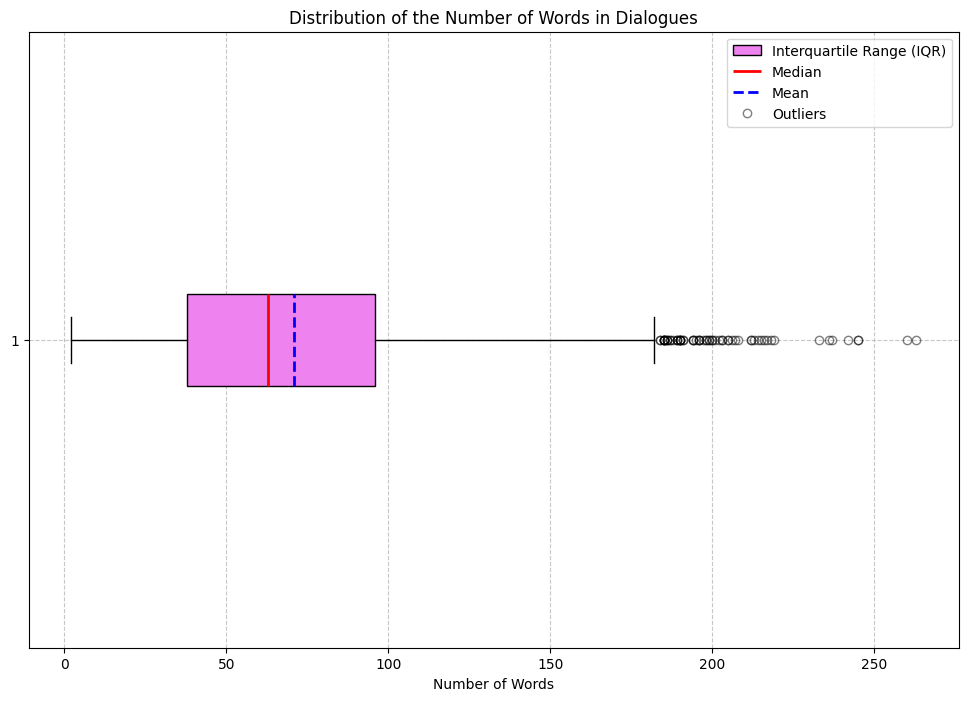

In [131]:
import matplotlib.pyplot as plt

# Box-plot
plt.figure(figsize=(12, 8))
box = plt.boxplot(df_length['total_word_length'], vert=False, patch_artist=True, 
                  boxprops=dict(facecolor='violet', color='black'), 
                  medianprops=dict(color='red', linewidth=2), 
                  meanline=True, showmeans=True, 
                  meanprops=dict(color='blue', linestyle='--', linewidth=2),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'),
                  flierprops=dict(marker='o', color='orange', alpha=0.5))

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Set labels and title
plt.xlabel("Number of Words")
plt.title("Distribution of the Number of Words in Dialogues")

# Add legend for clarity
plt.legend([box["boxes"][0], box["medians"][0], box["means"][0], box["fliers"][0]], 
           ['Interquartile Range (IQR)', 'Median', 'Mean', 'Outliers'],
           loc='upper right')

# Show plot
plt.show()


The maximum number of words in a dialogue is 263, so setting this as the MAX_LENGTH for padding would cover all utterances. However, a boxplot of the distribution reveals that only a few dialogues exceed 256 words, making those outliers.

Therefore, we choose 256, the nearest power of two, instead of 512, to efficiently handle most dialogues while minimizing padding.

### Tokenization step

In [ ]:
# Definition of tokenizer and useful hyperprameters
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 256
BATCH_SIZE = 32 

### Dataset definition, as expected by BERT-based classifiers

This class effectively prepares data for BERT by tokenizing each utterance and pairing it with its corresponding emotion and trigger labels. It handles padding, truncation, and encoding to make the data ready for model input.

We use the one-hot-encoding to encode emotions and triggers. 

While the utterances are encoded by the BERT Tokenizer using the encode_plus() method. It returns:
- `input_ids`: The tokenized representation of the utterance (BERT vocabulary).
- `attention_mask`: A mask to indicate which tokens are actual tokens (1) and which are padding (0).
- `token_type_ids`: For distinguishing between sentence pairs, but in this case, it's applied to a single utterance.

In [45]:
# Define the Class for the tokenized Dataset for BERT
class BERTDataset(Dataset):

    '''
    Class for the tokenized Dataset for BERT

    Args:
    dataframe: pd.DataFrame
    tokenizer: AutoTokenizer
    max_len: int

    Returns:
    dict: A dictionary containing the episode, input_ids, attention_mask, token_type_ids, target_emotion, and target_trigger
    '''

    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.emotions_encoded_dict = emotions_encoded_dict
        self.triggers_encoded_dict = triggers_encoded_dict
        self.data = self._create_data()
    
    # Split the Data into single sentences
    def _create_data(self):
        data = []
        for _, row in self.dataframe.iterrows():
            episode = row['episode']
            utterances = row["utterances"]
            emotions = row["emotions"]
            triggers = row["triggers"]
            for utterance, emotion, trigger in zip(utterances, emotions, triggers):
                data.append((episode, utterance, emotion, trigger))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        episode, utterance, emotion, trigger = self.data[index]
        target_emotion = self.emotions_encoded_dict[emotion]
        target_trigger = self.triggers_encoded_dict[trigger]

        encoding = self.tokenizer.encode_plus(
            utterance,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding="max_length",
            truncation=True,
        )

        input_ids = encoding["input_ids"]
        attention_mask = encoding["attention_mask"]
        token_type_ids = encoding["token_type_ids"]
        
        return {
            "episode": episode,
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_emotion": torch.tensor(target_emotion, dtype=torch.float),
            "target_trigger": torch.tensor(target_trigger, dtype=torch.float),
        }

The class will return a dictionary containing:
- `episode` : Id for the episode the utterance belongs to.
- `input_ids`, `attention_mask`, `token_type_ids`: Tokenized inputs that BERT model needs.
- `target_emotion` and `target_trigger` : one-hot-encoded labels for the emotion and triggers associates with the utterance.


In [46]:
# Create Datasets from training, validation and test DataFrames
bert_train_dataset = BERTDataset(df_train, tokenizer, MAX_LENGTH)
bert_test_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)
bert_val_dataset = BERTDataset(df_val, tokenizer, MAX_LENGTH)

# Data-loading step
train_loader= DataLoader(bert_train_dataset, batch_size=BATCH_SIZE, shuffle=True) #ricontrollare se shuffle deve essere true o false
test_loader = DataLoader(bert_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(bert_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [48]:
# Take a look at the structure of a tokenized row
print(train_loader.dataset[0])

{'episode': 'utterance_0', 'input_ids': tensor([  101,  2036,  1045,  2001,  1996,  2391,  2711,  2006,  2026,  2194,
         1005,  1055,  6653,  2013,  1996,  1047,  2140,  1011,  1019,  2000,
        24665,  1011,  1020,  2291,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   

In [50]:
# Print the keys in the DataLoader object
print(train_loader)
print('\n')

for batch in train_loader:
    print(batch.keys())
    break  # only prints the keys for the first batch, as the others have a similar structure



dict_keys(['episode', 'input_ids', 'attention_mask', 'token_type_ids', 'target_emotion', 'target_trigger'])


### BERT model definition

#### Our source was https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForPreTraining


BERTClass is a custom PyTorch model class, it is designed to perform two tasks simultaneously.

In [51]:
# Definition of BERT model Class
class BERTClass(torch.nn.Module):
    '''
    Class for the BERT model
    '''
    def __init__(self,model):
        '''
        Args:
        model: str
        '''

        super(BERTClass, self).__init__()
        #return a tuple
        self.l1 = transformers.AutoModel.from_pretrained(model, return_dict=False)
        # Emotions
        self.l2 = torch.nn.Dropout(p=0.3) #dropout layer
        self.l3 = torch.nn.Linear(self.l1.config.hidden_size, 7) #linear layer
        # Triggers
        self.l4 = torch.nn.Dropout(p=0.3) #dropout layer
        self.l5 = torch.nn.Linear(self.l1.config.hidden_size, 2) #linear layer

    def forward(self, ids, mask, token_type_ids, episode):

        '''
        Args:
        ids: torch.Tensor
        mask: torch.Tensor
        token_type_ids: torch.Tensor
        episode: str

        Returns:
        episode: str
        output_emotions: torch.Tensor
        output_trigger: torch.Tensor
        '''
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_emotions = self.l2(output_1)
        output_emotions = self.l3(output_emotions)
        output_trigger = self.l4(output_1)
        output_trigger = self.l5(output_trigger)
        return episode, output_emotions, output_trigger

This class utilizes the pre-trained BERT model to generate contextual embeddings for the input text. 

Then the embeddings are processed through separate dropout and linear layers to predict two different outputs: emotions and triggers. 

The dropout layers help prevent overfitting, and the linear layers transform the BERT embeddings into class scores for each task.

In [ ]:
# Use bert-base-uncased pre-trained model
model_name = 'bert-base-uncased'

# Define full model
full_model = BERTClass(model_name)
full_model.to(device)

# Define freezed model
freezed_model = BERTClass(model_name)
freezed_model.to(device)
# Freezing of parameters for freezed model
for param in freezed_model.l1.parameters():
    param.requires_grad = False

### Loss function

This function calculates a weighted binary cross-entropy loss for both emotion and trigger predictions.

It uses class weights to handle class imbalances and computes separate losses for each task, which are then summed to provide a final loss value for the model to optimize.

In [53]:
# Convert weights into tensors
emotions_weights_tensor = torch.tensor(list(emotions_weights_dict.values()), dtype=torch.float32).to(device)
triggers_weights_tensor = torch.tensor(list(triggers_weights_dict.values()), dtype=torch.float32).to(device)

# 2 weighted binary cross entropy losses, whose sum is the final output of the function

def weighted_binary_cross_entropy_loss(emotion_output, true_emotions, trigger_output, true_triggers, emotions_weights_tensor, triggers_weights_tensor):

    '''
    Args:
    emotion_output: torch.Tensor
    true_emotions: torch.Tensor
    trigger_output: torch.Tensor
    true_triggers: torch.Tensor
    emotions_weights_tensor: torch.Tensor
    triggers_weights_tensor: torch.Tensor

    Returns:
    loss_e_value + loss_t_value: torch.Tensor
    '''

    # Move tensors to device
    emotions_weights_tensor = emotions_weights_tensor.to(device)
    triggers_weights_tensor = triggers_weights_tensor.to(device)

    # Emotions loss function
    loss_emotions = torch.nn.BCEWithLogitsLoss(weight=emotions_weights_tensor)
    loss_e_value = loss_emotions(emotion_output, true_emotions)

    # Triggers loss function
    loss_triggers = torch.nn.BCEWithLogitsLoss(weight=triggers_weights_tensor)
    loss_t_value = loss_triggers(trigger_output, true_triggers)

    return loss_e_value + loss_t_value

### Validation function

This validation function evaluate the BERT model on the validation set by computing the loss and accuracy for both emorion and trigger tasks. We use the custom weighted binary cross-entropy loss function and calculate the overall performance of the model on the validation data without updating the model's parameters.

In [54]:
# Define validation function
def validation(model, val_loader, emotions_weights_tensor, triggers_weights_tensor):

    '''
    Args:
    model: BERTClass
    val_loader: DataLoader
    emotions_weights_tensor: torch.Tensor
    triggers_weights_tensor: torch.Tensor

    Returns:
    val_loss: float
    accuracy_emotion: float
    accuracy_trigger: float
    '''

    model.eval()
    # Initaite variables for iteration
    val_loss = 0
    correct_emotion = 0
    correct_trigger = 0
    total_emotion = 0
    total_trigger = 0

    with torch.no_grad():
        # Iterate on each validation set batch
        for _, data in enumerate(val_loader, 0):
            # Move tokenization logits on device
            episode = data['episode']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)
            # Generate emotions and trigger outputs
            _, emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids, episode)
            # Caluclate loss using the defined function
            val_loss += weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)

            # Compute accuracy
            predicted_emotion = torch.round(torch.sigmoid(emotion_output))
            predicted_trigger = torch.round(torch.sigmoid(trigger_output))
            correct_emotion += (predicted_emotion == target_emotion).sum().item()
            total_emotion += target_emotion.numel()  # Total number of elements in target_emotion
            correct_trigger += (predicted_trigger == target_trigger).sum().item()
            total_trigger += target_trigger.numel()  # Total number of elements in target_trigger
            
    # Calculate average loss and accuracy
    val_loss /= len(val_loader)
    accuracy_emotion = correct_emotion / total_emotion
    accuracy_trigger = correct_trigger / total_trigger

    return val_loss, accuracy_emotion, accuracy_trigger

### Training and Validation

This function trains the model over multiple epochs, calculates losses, validates the model on the val dataset, and implements early stopping if no improvements are seen in validation loss. It also saves the best-performing model checkpoint to the specified path.

In [55]:
def train_model(model, train_loader, validation_loader, emotions_weights_tensor, triggers_weights_tensor, num_epochs, patience, checkpoint_path, learning_rate):

    '''
    Args:
    model: BERTClass
    train_loader: DataLoader
    validation_loader: DataLoader
    emotions_weights_tensor: torch.Tensor
    triggers_weights_tensor: torch.Tensor
    num_epochs: int
    patience: int
    checkpoint_path: str
    learning_rate: float
    '''

    # Initiate Adam optimizer and some useful variables for iteration
    size = len(train_loader.dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    patience_counter = 0

    # Move model to GPU
    model.to(device)
    
    # Iterate over num_epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}.')
        model.train()  # Set the model in train mode
        train_loss = 0.0
        
        # Iterate over every batch in the training set
        for batch, data in enumerate(train_loader, 0):
            # Move tokenization logits to device
            episode = data['episode']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)
            optimizer.zero_grad()

            # Generate model predictions
            _, emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids, episode)

            # Compute loss using the defined function and utilizes it for updating model weights invoking the optimizer
            loss = weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)
            loss.backward()
            optimizer.step()
            
            # Update loss counter
            train_loss += loss.item()
            
            if batch%5000==0:
              current =  batch * len(data['input_ids'])
              print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
        
        # Calculate average loss over training set
        train_loss /= len(train_loader)

        # Invoke validation function
        val_loss, val_accuracy_emotion, val_accuracy_trigger = validation(model, validation_loader, emotions_weights_tensor, triggers_weights_tensor)

        # Print the computations
        print(f'Epoch {epoch+1}/{num_epochs}, Average Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy Emotion: {val_accuracy_emotion:.4f}, Val Accuracy Trigger: {val_accuracy_trigger:.4f}')

        # Manage early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved to {checkpoint_path}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break
        print('\n')
        
print('\n')

#### Hyperparameters
Now, we turn our attention to finding the optimal hyperparameter configuration.

Our goal is to strike the best balance between maximizing the performance of both classification (emotions and triggers). To achieve this, we focus on optimizing for the average accuracy across both tasks.

The code used for this search is the following:

In [ ]:
# Define the hyperparameter grid

hyperparameter_grid = {
    'seeds': [42, 123, 200, 322, 506],
    'epochs': [3, 5],
    'learning_rate': [1e-5, 5e-5],
    'patience': [2, 5]
}


# Function to train and evaluate both models
def train_and_evaluate_models(full_model, freezed_model, train_loader, val_loader, max_length, seed, epochs, full_model_checkpoint_path, freezed_model_checkpoint_path, learning_rate, patience):
    
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    
    # Train the full model
    train_model(full_model, train_loader, val_loader, emotions_weights_tensor, triggers_weights_tensor, epochs, patience, full_model_checkpoint_path, learning_rate)
    
    
    # Evaluate the full model
    _, accuracy_emotion_full, accuracy_trigger_full = validation(full_model, val_loader, emotions_weights_tensor, triggers_weights_tensor)
    
    # Train the freezed model
    train_model(freezed_model, train_loader, val_loader, emotions_weights_tensor, triggers_weights_tensor, epochs, patience, freezed_model_checkpoint_path, learning_rate)
    
    # Evaluate the freezed model
    _, accuracy_emotion_freezed, accuracy_trigger_freezed = validation(freezed_model, val_loader, emotions_weights_tensor, triggers_weights_tensor)
    
    # Calculate the average accuracy for both models
    average_accuracy = (accuracy_emotion_full + accuracy_trigger_full + accuracy_emotion_freezed + accuracy_trigger_freezed) / 4
    
    return average_accuracy


# Initialize variables to track the best hyperparameters
best_average_accuracy = 0
best_hyperparameters = None

# Paths to the pre-trained model checkpoints
full_model_checkpoint_path = 'full_best_model.pth'
freezed_model_checkpoint_path = 'freezed_best_model.pth'

# Iterate over all combinations of hyperparameters
for seed, epochs, learning_rate, patience in itertools.product(
        hyperparameter_grid['seeds'],
        hyperparameter_grid['epochs'],
        hyperparameter_grid['learning_rate'],
        hyperparameter_grid['patience']):
    
    # Train and evaluate both models
    average_accuracy = train_and_evaluate_models(full_model, freezed_model, train_loader, val_loader, max_length, seed, epochs, full_model_checkpoint_path, freezed_model_checkpoint_path, learning_rate, patience)
    
    # Update the best hyperparameters if the current combination is better
    if average_accuracy > best_average_accuracy:
        best_average_accuracy = average_accuracy
        best_hyperparameters = {
            'seed': seed,
            'epochs': epochs,
            'learning_rate': learning_rate,
            'patience': patience
        }

print(f'Best Average Accuracy: {best_average_accuracy}')
print(f'Best Hyperparameters: {best_hyperparameters}')

#### The best configuration average_accuracy = 0.865597830421951.

We now train and evaluate both models using the selected hyperparameters:

In [56]:
# Define the best configuration of hyperparameters
seed = 42
epochs = 5
learning_rate = 5e-5
patience = 2 

# Set the seed for reproducibility
torch.manual_seed(seed);

#### Training of full model

In [58]:
# Invoke training function for full model
train_model(full_model, train_loader, val_loader,  emotions_weights_tensor, triggers_weights_tensor, epochs, patience, 'full_best_model.pth', learning_rate)

print("Training completed for full model!")

Epoch 1/5.
Train loss: 3.695890  [    0/27885]
Epoch 1/5, Average Train Loss: 1.3352, Val Loss: 1.4648, Val Accuracy Emotion: 0.8873, Val Accuracy Trigger: 0.8548
Model saved to full_best_model.pth


Epoch 2/5.
Train loss: 1.012529  [    0/27885]
Epoch 2/5, Average Train Loss: 1.0354, Val Loss: 1.6255, Val Accuracy Emotion: 0.8851, Val Accuracy Trigger: 0.8548


Epoch 3/5.
Train loss: 1.199360  [    0/27885]
Epoch 3/5, Average Train Loss: 0.9269, Val Loss: 1.7620, Val Accuracy Emotion: 0.8809, Val Accuracy Trigger: 0.8505
Early stopping
Training completed for full model!


The training results show the performance over three epochs with early stopping occurring at the end of the third epoch.

| Epoch  | Av Train Loss | Val Loss | Emotion Acc | Trigger Acc |
| :----  | :------:      | :----:   |:----:       |  :----:     |
| **Epoch 1**|**1.3352**| **1.4648**|**0.8873**|**0.8548**|
| Epoch 2|1.0354| 1.6255|0.8851|0.8548|
| Epoch 3|0.9269|1.7620 |0.8809|0.8505|

The best model was saved after Epoch 1.

The model achieved strong initial performance, but validation loss increased after the first epoch, suggesting overfitting. Early stopping successfully prevented further degradation in performance, ending the training after three epochs.

#### Training of freezed model

In [57]:
# Invoke training function for freezed model
train_model(freezed_model, train_loader, val_loader,  emotions_weights_tensor, triggers_weights_tensor, epochs, patience, 'freezed_best_model.pth', learning_rate)

print("Training completed for freezed model!")

Epoch 1/5.
Train loss: 2.775041  [    0/27885]
Epoch 1/5, Average Train Loss: 1.7173, Val Loss: 1.5603, Val Accuracy Emotion: 0.8587, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 2/5.
Train loss: 1.755713  [    0/27885]
Epoch 2/5, Average Train Loss: 1.6222, Val Loss: 1.5428, Val Accuracy Emotion: 0.8664, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 3/5.
Train loss: 1.546618  [    0/27885]
Epoch 3/5, Average Train Loss: 1.6089, Val Loss: 1.5305, Val Accuracy Emotion: 0.8674, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 4/5.
Train loss: 1.295967  [    0/27885]
Epoch 4/5, Average Train Loss: 1.5953, Val Loss: 1.5213, Val Accuracy Emotion: 0.8678, Val Accuracy Trigger: 0.8548
Model saved to freezed_best_model.pth


Epoch 5/5.
Train loss: 1.714148  [    0/27885]
Epoch 5/5, Average Train Loss: 1.5830, Val Loss: 1.5135, Val Accuracy Emotion: 0.8688, Val Accuracy Trigger: 0.8548
Model saved to freezed_be

The freezed model demonstrated consistent improvements across epochs, with both validation loss and emotion accuracy improving, while trigger accuracy remained stable. 

The model was saved after every epoch due to better performance compared to the previous one.

#### Comparison between models

| **Epoch** | **Model**  | **Average Train Loss** | **Val Loss** | **Val Accuracy (Emotion)** | **Val Accuracy (Trigger)** | **Model Saved** |
|-----------|------------|------------------------|--------------|----------------------------|----------------------------|-----------------|
|**1**        | **Full**       | 1.3352                 | 1.4648       | 0.8873                     | 0.8548                     | Yes             |
| 2         | Full       | 1.0354                 | 1.6255       | 0.8851                     | 0.8548                     | No              |
| 3         | Full       | 0.9269                 | 1.7620       | 0.8809                     | 0.8505                     | No              |
| 1         | Freezed    | 1.7173                 | 1.5603       | 0.8587                     | 0.8548                     | Yes             |
| 2         | Freezed    | 1.6222                 | 1.5428       | 0.8664                     | 0.8548                     | Yes             |
| 3         | Freezed    | 1.6089                 | 1.5305       | 0.8674                     | 0.8548                     | Yes             |
| 4         | Freezed    | 1.5953                 | 1.5213       | 0.8678                     | 0.8548                     | Yes             |
| **5**         | **Freezed**    |**1.5830**              | **1.5135**       | **0.8688**                     | **0.8548**                     | **Yes**             |


The table shows that the **full model** achieved better initial performance with lower train and validation loss, though it did not improve after the first epoch, leading to early stopping.

In contrast, the **freezed model** exhibited gradual improvement across all epochs, consistently reducing validation loss and slightly improving emotion accuracy while maintaining stable trigger accuracy.

In [132]:
import pandas as pd

# Data from the table
data_train = {
    'Epoch': [1, 2, 3, 1, 2, 3, 4, 5],
    'Model': ['Full', 'Full', 'Full', 'Freezed', 'Freezed', 'Freezed', 'Freezed', 'Freezed'],
    'Average Train Loss': [1.3352, 1.0354, 0.9269, 1.7173, 1.6222, 1.6089, 1.5953, 1.5830],
    'Val Loss': [1.4648, 1.6255, 1.7620, 1.5603, 1.5428, 1.5305, 1.5213, 1.5135],
    'Val Accuracy (Emotion)': [0.8873, 0.8851, 0.8809, 0.8587, 0.8664, 0.8674, 0.8678, 0.8688],
    'Val Accuracy (Trigger)': [0.8548, 0.8548, 0.8505, 0.8548, 0.8548, 0.8548, 0.8548, 0.8548]
}

df_data_train = pd.DataFrame(data_train)

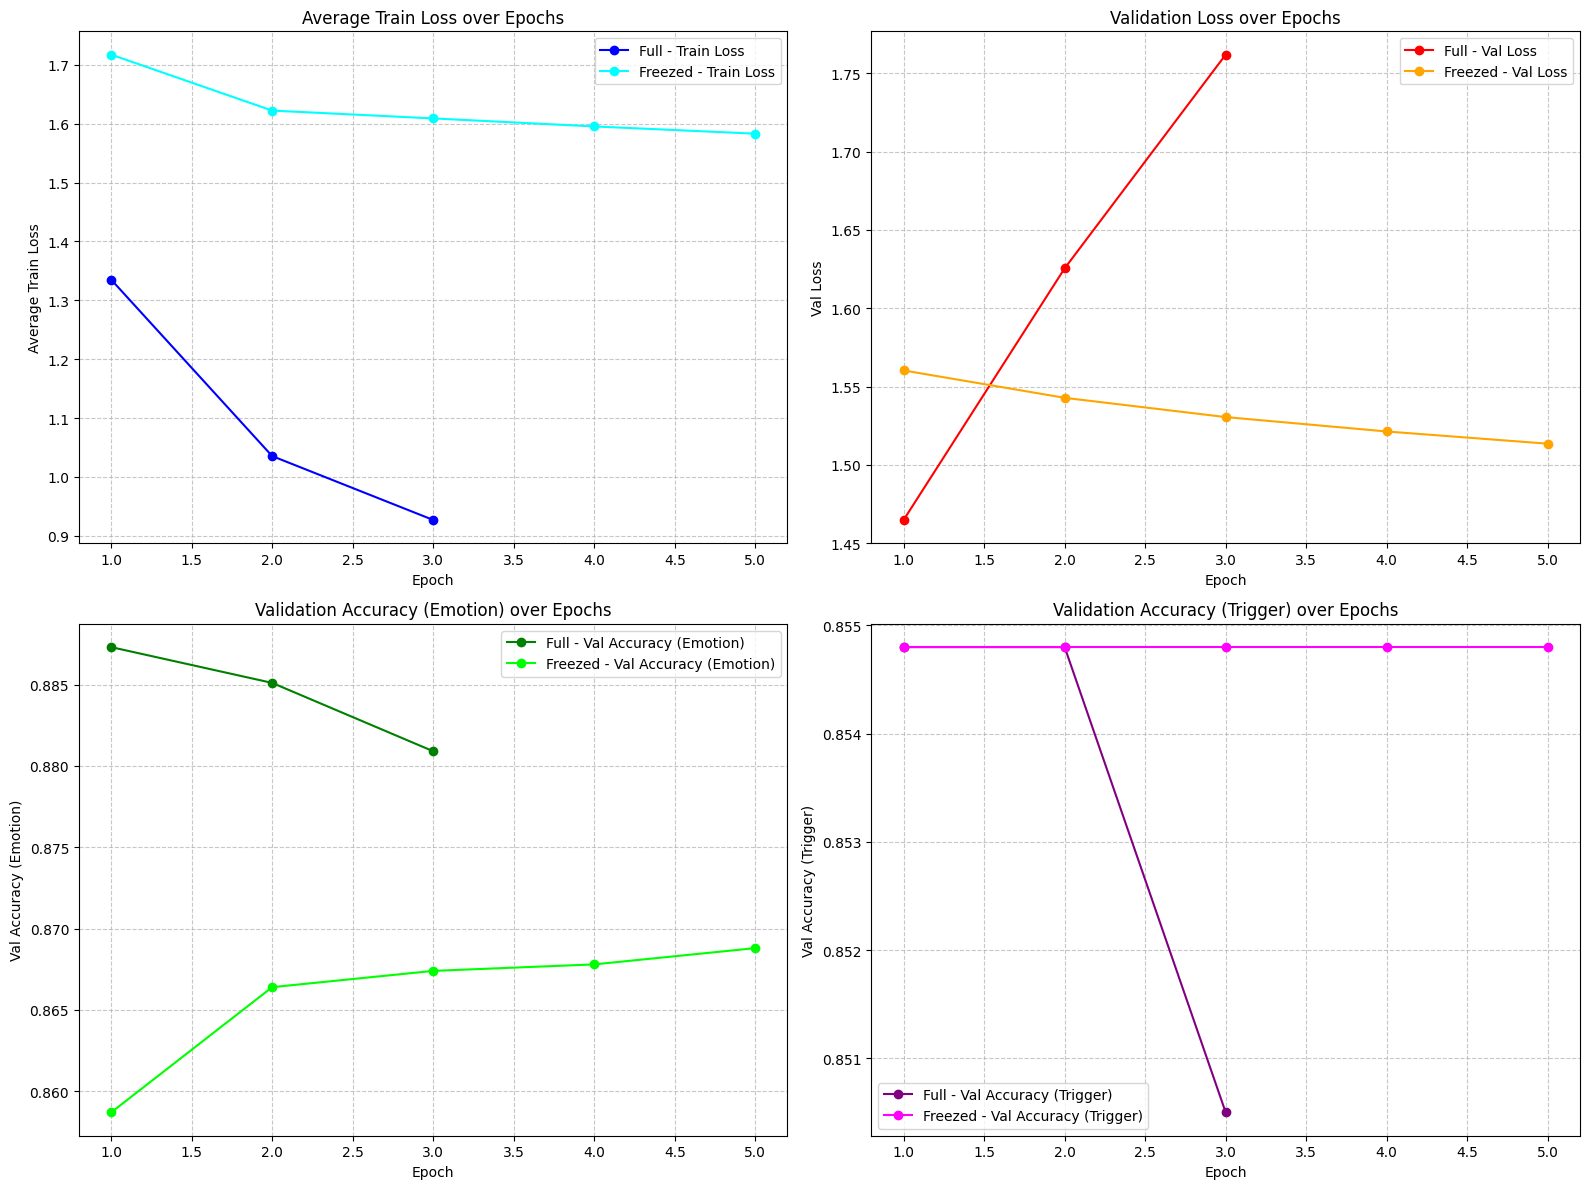

In [134]:
import matplotlib.pyplot as plt

# Separate data for Full and Freezed models
df_full = df_data_train[df_data_train['Model'] == 'Full']
df_freezed = df_data_train[df_data_train['Model'] == 'Freezed']

# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot Average Train Loss
axs[0, 0].plot(df_full['Epoch'], df_full['Average Train Loss'], marker='o', label='Full - Train Loss', color='blue')
axs[0, 0].plot(df_freezed['Epoch'], df_freezed['Average Train Loss'], marker='o', label='Freezed - Train Loss', color='cyan')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Average Train Loss')
axs[0, 0].set_title('Average Train Loss over Epochs')
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot Val Loss
axs[0, 1].plot(df_full['Epoch'], df_full['Val Loss'], marker='o', label='Full - Val Loss', color='red')
axs[0, 1].plot(df_freezed['Epoch'], df_freezed['Val Loss'], marker='o', label='Freezed - Val Loss', color='orange')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Val Loss')
axs[0, 1].set_title('Validation Loss over Epochs')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Plot Val Accuracy (Emotion)
axs[1, 0].plot(df_full['Epoch'], df_full['Val Accuracy (Emotion)'], marker='o', label='Full - Val Accuracy (Emotion)', color='green')
axs[1, 0].plot(df_freezed['Epoch'], df_freezed['Val Accuracy (Emotion)'], marker='o', label='Freezed - Val Accuracy (Emotion)', color='lime')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Val Accuracy (Emotion)')
axs[1, 0].set_title('Validation Accuracy (Emotion) over Epochs')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot Val Accuracy (Trigger)
axs[1, 1].plot(df_full['Epoch'], df_full['Val Accuracy (Trigger)'], marker='o', label='Full - Val Accuracy (Trigger)', color='purple')
axs[1, 1].plot(df_freezed['Epoch'], df_freezed['Val Accuracy (Trigger)'], marker='o', label='Freezed - Val Accuracy (Trigger)', color='magenta')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Val Accuracy (Trigger)')
axs[1, 1].set_title('Validation Accuracy (Trigger) over Epochs')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

### Evaluation function

This function evaluates the performance of the trained model on the test set. It calculates the test loss and collect all model predictions and true labels for emotions and triggers.

In [59]:
def evaluation(model, test_loader, emotions_weights_tensor, triggers_weights_tensor):

    '''
    Args:
    model: BERTClass
    test_loader: DataLoader
    emotions_weights_tensor: torch.Tensor
    triggers_weights_tensor: torch.Tensor
    
    Returns:
    all_emotion_outputs: torch.Tensor
    all_trigger_outputs: torch.Tensor
    all_target_emotions: torch.Tensor
    all_target_triggers: torch.Tensor
    all_episodes: list
    '''

    model.eval()  # Set the model in evaluation mode
    # Initiate useful variables for iteration
    test_loss = 0.0
    all_episodes = []
    all_emotion_outputs = []
    all_trigger_outputs = []
    all_target_emotions = []
    all_target_triggers = []

    with torch.no_grad():  
        # Iterate over every batch in test set
        for data in test_loader:
            # Move tokenization logits in device
            episode = data['episode']
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            target_emotion = data['target_emotion'].to(device)
            target_trigger = data['target_trigger'].to(device)

            # Model predictions
            episode, emotion_output, trigger_output = model(input_ids, attention_mask, token_type_ids, episode)

            # Calculate loss
            loss = weighted_binary_cross_entropy_loss(emotion_output, target_emotion, trigger_output, target_trigger, emotions_weights_tensor, triggers_weights_tensor)
            test_loss += loss.item()

            # Save episodes, outputs and targets
            all_episodes.extend(episode)
            all_emotion_outputs.append(emotion_output.cpu())
            all_trigger_outputs.append(trigger_output.cpu())
            all_target_emotions.append(target_emotion.cpu())
            all_target_triggers.append(target_trigger.cpu())
    
    # Calculate average test loss
    test_loss /= len(test_loader)

    # Concatenate all outputs and targets
    
    all_emotion_outputs = torch.cat(all_emotion_outputs, dim=0)
    all_trigger_outputs = torch.cat(all_trigger_outputs, dim=0)
    all_target_emotions = torch.cat(all_target_emotions, dim=0)
    all_target_triggers = torch.cat(all_target_triggers, dim=0)

    print(f'Test Loss: {test_loss:.4f}')

    return all_emotion_outputs, all_trigger_outputs, all_target_emotions, all_target_triggers, all_episodes

#### Evaluation of full model

In [60]:
# Set the model to the last checkpoint configuration
checkpoint_path = 'full_best_model.pth'
full_model.load_state_dict(torch.load(checkpoint_path))

# Invoke evaluation function for full model
all_emotion_outputs_full, all_trigger_outputs_full, all_target_emotions_full, all_target_triggers_full, all_episodes_full = evaluation(full_model, test_loader, emotions_weights_tensor, triggers_weights_tensor)

/tmp/ipykernel_36/57633672.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_model.load_state_dict(torch.load(checkpoint_path))


Test Loss: 1.4648


In [61]:
# Take a look to outputs
print(all_emotion_outputs_full) 
print(all_trigger_outputs_full)

tensor([[ 2.6767, -4.5354, -3.8116,  ..., -2.8914, -3.8298, -3.6036],
        [-0.6546, -4.5759,  0.8211,  ..., -3.5331, -4.9165, -4.0335],
        [-0.9633, -0.5778, -4.0516,  ..., -2.2650, -3.3263, -3.4162],
        ...,
        [ 2.6068, -4.5520, -4.6262,  ..., -2.8838, -3.4995, -3.1667],
        [-1.7271, -4.1813, -3.5428,  ..., -1.0532, -2.2506, -2.6253],
        [ 3.0906, -3.9449, -4.5991,  ..., -3.6309, -5.0720, -4.2032]])
tensor([[ 1.8503, -1.7804],
        [ 2.4153, -2.3691],
        [ 0.9477, -0.8237],
        ...,
        [ 1.5081, -1.2212],
        [ 1.4230, -1.1605],
        [ 2.3001, -2.6512]])


In [62]:
# Set the model to the last checkpoint configuration
checkpoint_path = 'freezed_best_model.pth'
freezed_model.load_state_dict(torch.load(checkpoint_path))
# Invoke evaluation function for freezed model
all_emotion_outputs_freezed, all_trigger_outputs_freezed, all_target_emotions_freezed, all_target_triggers_freezed, all_episodes_freezed = evaluation(freezed_model, test_loader, emotions_weights_tensor, triggers_weights_tensor)

/tmp/ipykernel_36/2510102751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  freezed_model.load_state_dict(torch.load(checkpoint_path))


Test Loss: 1.5135


In [63]:
# Take a look to outputs
print(all_emotion_outputs_freezed) 
print(all_trigger_outputs_freezed) 

tensor([[ 0.0770, -1.3363, -2.1293,  ..., -2.4710, -3.2903, -3.0610],
        [-0.4354, -2.0544, -0.8122,  ..., -2.5291, -3.9452, -3.5311],
        [ 0.0718, -1.6147, -2.7669,  ..., -2.5018, -3.4714, -3.1401],
        ...,
        [-0.0228, -1.7618, -2.2967,  ..., -2.1513, -3.2613, -2.9984],
        [-0.4005, -1.8845, -1.5477,  ..., -2.4381, -3.6132, -3.2977],
        [ 0.3871, -1.9562, -1.8851,  ..., -2.9722, -3.7790, -3.2333]])
tensor([[ 1.6789, -1.7769],
        [ 2.1774, -2.1750],
        [ 1.5313, -1.5814],
        ...,
        [ 1.5749, -1.5795],
        [ 1.8885, -1.8780],
        [ 2.0257, -2.0811]])


The test results show that:

- The full model achieved a test loss of 1.4648.
- The freezed model achieved a test loss of 1.5135.

This indicates that the full model performed slightly better on the test set compared to the freezed model, with a lower test loss.

#### Defining a DataFrame with predictions and targets

In [64]:
def tensor_to_dataframe(emotion_outputs, trigger_outputs, target_emotions, target_triggers, episodes):
    '''
    Args:
    emotion_outputs: torch.Tensor
    trigger_outputs: torch.Tensor
    target_emotions: torch.Tensor
    target_triggers: torch.Tensor
    episodes: list

    Returns:
    df: pd.DataFrame
    '''
    data = {
        'episode' : [episode for episode in episodes],
        'predicted_emotions': [output for output in emotion_outputs], # Predicitions are kept in logits form
        'predicted_triggers': [output for output in trigger_outputs],
        'target_emotions': [target.tolist() for target in target_emotions], # Targets are converted to lists
        'target_triggers': [target.tolist() for target in target_triggers]
    }
    # Convert into a DataFrame
    df = pd.DataFrame(data)
    return df

# Invoke the function on the targets and on the predictions of the two models
results_df_full = tensor_to_dataframe(all_emotion_outputs_full, all_trigger_outputs_full, all_target_emotions_full, all_target_triggers_full, all_episodes_full) 
results_df_freezed = tensor_to_dataframe(all_emotion_outputs_freezed, all_trigger_outputs_freezed, all_target_emotions_freezed, all_target_triggers_freezed, all_episodes_freezed)

In [65]:
# Take a look to the structure of one of the defined DataFrames
print(results_df_full.head())

          episode                                 predicted_emotions  \
0  utterance_3603  [tensor(2.6767), tensor(-4.5354), tensor(-3.81...   
1  utterance_3603  [tensor(-0.6546), tensor(-4.5759), tensor(0.82...   
2  utterance_3603  [tensor(-0.9633), tensor(-0.5778), tensor(-4.0...   
3  utterance_3603  [tensor(-0.6546), tensor(-4.5759), tensor(0.82...   
4  utterance_3603  [tensor(3.4029), tensor(-4.2132), tensor(-4.95...   

                  predicted_triggers                      target_emotions  \
0  [tensor(1.8503), tensor(-1.7804)]  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1  [tensor(2.4153), tensor(-2.3691)]  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]   
2  [tensor(0.9477), tensor(-0.8237)]  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
3  [tensor(2.4153), tensor(-2.3691)]  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]   
4  [tensor(1.7557), tensor(-1.7711)]  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

  target_triggers  
0      [1.0, 0.0]  
1      [1.0, 0.0]  
2      [1.0, 0.0]  
3      [1.0, 0.0]  
4   

#### We now plot some preliminar results on the two models: the following functions decode the labels and plots  classification reports and heatmaps of correlation matrices

In [66]:
# Function to convert tensors to one-hot encoded arrays
def convert_to_one_hot(tensor_array):
    one_hot_array = np.zeros_like(tensor_array)
    one_hot_array[tensor_array.argmax(0)] = 1
    return one_hot_array

# Functions to decode one-hot encoded arrays to labels
def decode_emotions(one_hot_array, emotions_encoded_dict):
    reverse_dict = {tuple(v): k for k, v in emotions_encoded_dict.items()}
    return [reverse_dict[tuple(arr)] for arr in one_hot_array]

def decode_triggers(one_hot_array, triggers_encoded_dict):
    reverse_dict = {tuple(v): k for k, v in triggers_encoded_dict.items()}
    return [reverse_dict[tuple(arr)] for arr in one_hot_array]

# Function to process the DataFrame
def process_dataframe(df, emotions_encoded_dict, triggers_encoded_dict):
    # Convert tensors to one-hot encoded arrays
    df['predicted_emotions'] = df['predicted_emotions'].apply(lambda x: convert_to_one_hot(np.array(x)))
    df['predicted_triggers'] = df['predicted_triggers'].apply(lambda x: convert_to_one_hot(np.array(x)))
    
    # Decode one-hot encoded arrays to labels
    df['predicted_emotions_decoded'] = decode_emotions(df['predicted_emotions'], emotions_encoded_dict)
    df['target_emotions_decoded'] = decode_emotions(df['target_emotions'], emotions_encoded_dict)
    df['predicted_triggers_decoded'] = decode_triggers(df['predicted_triggers'], triggers_encoded_dict)
    df['target_triggers_decoded'] = decode_triggers(df['target_triggers'], triggers_encoded_dict)
    
    return df

# Function to calculate correlation matrices and classification reports
def calculate_metrics(df):
    # Generate correlation matrices
    emotions_corr_matrix = pd.crosstab(df['predicted_emotions_decoded'], df['target_emotions_decoded'])
    triggers_corr_matrix = pd.crosstab(df['predicted_triggers_decoded'], df['target_triggers_decoded'])
    # Generate classification reports
    emotions_classification_report = classification_report(df['target_emotions_decoded'], df['predicted_emotions_decoded'])
    triggers_classification_report = classification_report(df['target_triggers_decoded'], df['predicted_triggers_decoded'])
    
    return emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report

# Function to plot heatmaps
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(title)
    plt.show()

#### Heatmaps for full model

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

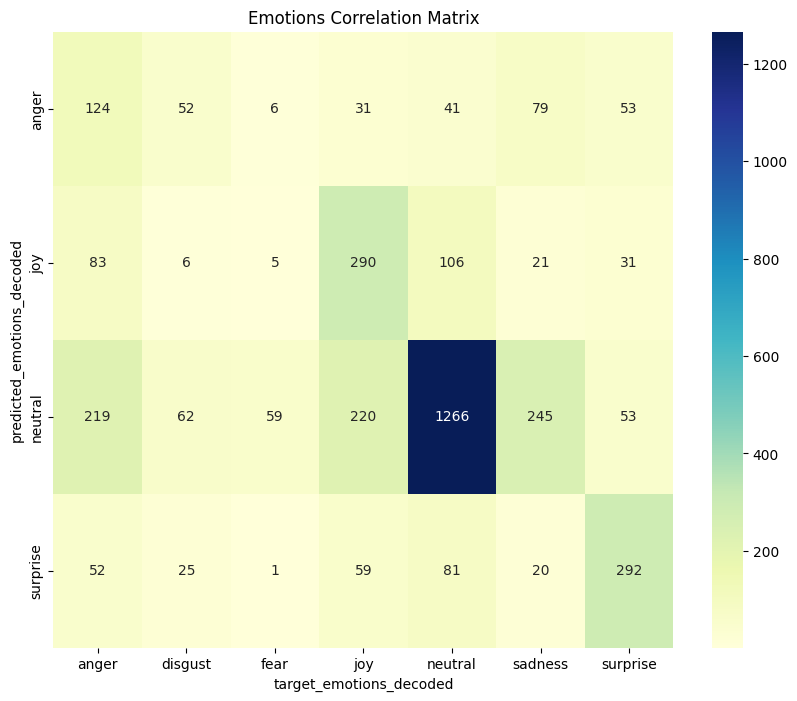

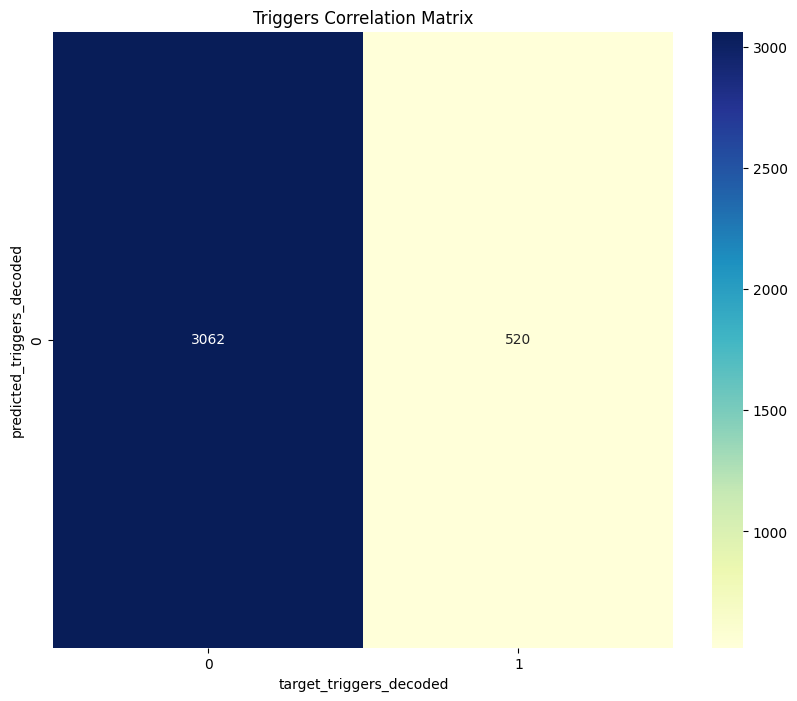

In [67]:
# Decoding the labels
results_df_full = process_dataframe(results_df_full, emotions_encoded_dict, triggers_encoded_dict)

# Generating correlation matrices and classification reports 
emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report = calculate_metrics(results_df_full)

# Plot heatmaps
plot_heatmap(emotions_corr_matrix, "Emotions Correlation Matrix")
plot_heatmap(triggers_corr_matrix, "Triggers Correlation Matrix")

#### Classification reports for full model

In [68]:
# Printing classification reports
print("Emotions Classification Report:\n", emotions_classification_report)
print("Triggers Classification Report:\n", triggers_classification_report)

Emotions Classification Report:
               precision    recall  f1-score   support

       anger       0.32      0.26      0.29       478
     disgust       0.00      0.00      0.00       145
        fear       0.00      0.00      0.00        71
         joy       0.54      0.48      0.51       600
     neutral       0.60      0.85      0.70      1494
     sadness       0.00      0.00      0.00       365
    surprise       0.55      0.68      0.61       429

    accuracy                           0.55      3582
   macro avg       0.29      0.32      0.30      3582
weighted avg       0.45      0.55      0.49      3582

Triggers Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      3062
           1       0.00      0.00      0.00       520

    accuracy                           0.85      3582
   macro avg       0.43      0.50      0.46      3582
weighted avg       0.73      0.85      0.79      3582



#### Heatmaps for freezed model

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

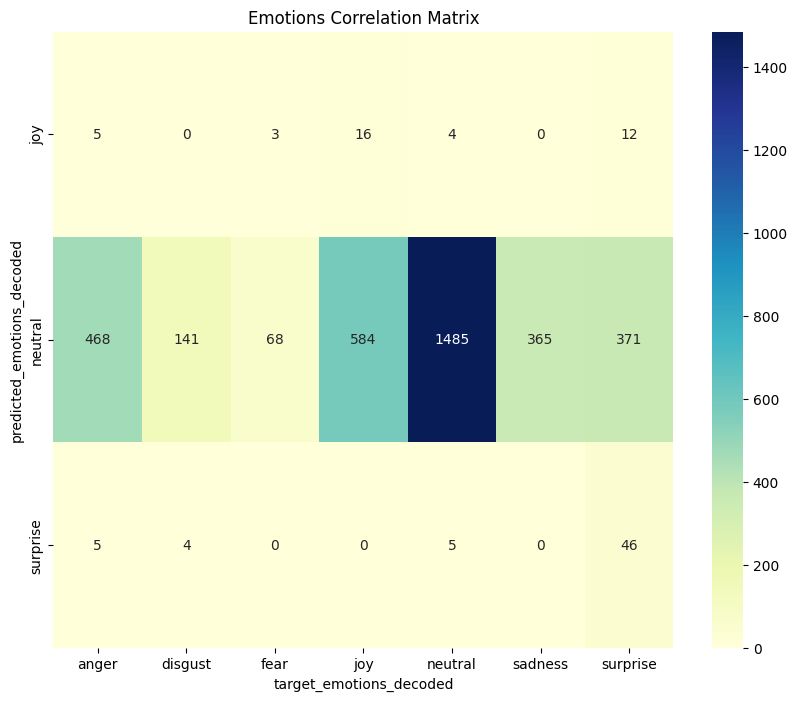

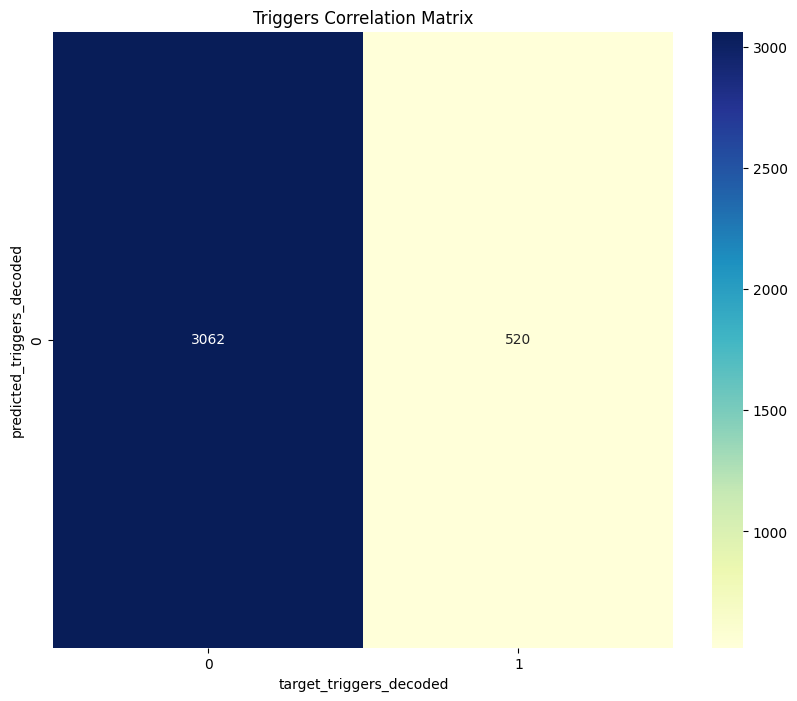

In [69]:
# Decoding the labels
results_df_freezed = process_dataframe(results_df_freezed, emotions_encoded_dict, triggers_encoded_dict)

# Generating correlation matrices and classification reports 
emotions_corr_matrix, triggers_corr_matrix, emotions_classification_report, triggers_classification_report = calculate_metrics(results_df_freezed)

# Plot heatmaps
plot_heatmap(emotions_corr_matrix, "Emotions Correlation Matrix")
plot_heatmap(triggers_corr_matrix, "Triggers Correlation Matrix")

#### Classification reports for freezed model

In [70]:
# Printing classification reports
print("Emotions Classification Report:\n", emotions_classification_report)
print("Triggers Classification Report:\n", triggers_classification_report)

Emotions Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       478
     disgust       0.00      0.00      0.00       145
        fear       0.00      0.00      0.00        71
         joy       0.40      0.03      0.05       600
     neutral       0.43      0.99      0.60      1494
     sadness       0.00      0.00      0.00       365
    surprise       0.77      0.11      0.19       429

    accuracy                           0.43      3582
   macro avg       0.23      0.16      0.12      3582
weighted avg       0.34      0.43      0.28      3582

Triggers Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      3062
           1       0.00      0.00      0.00       520

    accuracy                           0.85      3582
   macro avg       0.43      0.50      0.46      3582
weighted avg       0.73      0.85      0.79      3582



### Evaluation Metrics Definition

#### Definition of Average F1 score for the two models: the function computes the F1 score for each row; then, an average is computed over each dialogue; finally, an average over all the dialogues is returned.

In [71]:
def calculate_average_f1_score(df):
    # Calculate F1 score for each row
    df['f1_emotions'] = df.apply(lambda row: f1_score([row['target_emotions_decoded']], [row['predicted_emotions_decoded']], average='weighted'), axis=1)
    df['f1_triggers'] = df.apply(lambda row: f1_score([row['target_triggers_decoded']], [row['predicted_triggers_decoded']], average='weighted'), axis=1)
    
    # Group by 'episode' and calculate average F1 score for each dialogue
    grouped = df.groupby('episode').agg({
        'f1_emotions': 'mean',
        'f1_triggers': 'mean'
    }).reset_index()
    
    # Calculate the overall average F1 score
    average_f1_emotions = grouped['f1_emotions'].mean()
    average_f1_triggers = grouped['f1_triggers'].mean()
    
    return average_f1_emotions, average_f1_triggers

#### Computation of Average F1 score for the two models

In [72]:
# Calculate average f1 score for the two models
average_f1_emotions_full, average_f1_triggers_full = calculate_average_f1_score(results_df_full)
average_f1_emotions_freezed, average_f1_triggers_freezed = calculate_average_f1_score(results_df_freezed)

# Print the obtained scores
print('FULL MODEL:')
print("Average F1 Score for Emotions:", average_f1_emotions_full)
print("Average F1 Score for Triggers:", average_f1_triggers_full)
print('\n')
print('FREEZED MODEL:')
print("Average F1 Score for Emotions:", average_f1_emotions_freezed)
print("Average F1 Score for Triggers:", average_f1_triggers_freezed)

FULL MODEL:
Average F1 Score for Emotions: 0.5677400693190218
Average F1 Score for Triggers: 0.8093200770801751


FREEZED MODEL:
Average F1 Score for Emotions: 0.42978778427026876
Average F1 Score for Triggers: 0.8093200770801751


#### Definition of Unrolled F1 score for the two models: the function computes the F1 score for each row; then, a per-category and a global average are computed over all the rows.

In [75]:
def compute_unrolled_f1_score(df):
    # Calculate F1 score for each row
    df['f1_emotions'] = df.apply(lambda row: f1_score([row['target_emotions_decoded']], [row['predicted_emotions_decoded']], average='weighted'), axis=1)
    df['f1_triggers'] = df.apply(lambda row: f1_score([row['target_triggers_decoded']], [row['predicted_triggers_decoded']], average='weighted'), axis=1)
    
    # Calculate global unrolled F1 score
    global_unrolled_f1_emotions = df['f1_emotions'].mean()
    global_unrolled_f1_triggers = df['f1_triggers'].mean()
    
    # Group by target_emotions_decoded and target_triggers_decoded and calculate average F1 score for each group
    grouped_unrolled_f1_emotions = df.groupby('target_emotions_decoded')['f1_emotions'].mean().reset_index()
    grouped_unrolled_f1_triggers = df.groupby('target_triggers_decoded')['f1_triggers'].mean().reset_index()
    
    return global_unrolled_f1_emotions, global_unrolled_f1_triggers, grouped_unrolled_f1_emotions, grouped_unrolled_f1_triggers

#### Computation of Unrolled F1 score for the two models

In [76]:
# Calculate unrolled F1 score for the two models
global_unrolled_f1_emotions_full, global_unrolled_f1_triggers_full, grouped_unrolled_f1_emotions_full, grouped_unrolled_f1_triggers_full = compute_unrolled_f1_score(results_df_full)
global_unrolled_f1_emotions_freezed, global_unrolled_f1_triggers_freezed, grouped_unrolled_f1_emotions_freezed, grouped_unrolled_f1_triggers_freezed = compute_unrolled_f1_score(results_df_freezed)

# Print the obtained scores
print('FULL MODEL:')
print("Global Unrolled F1 Score for Emotions:", global_unrolled_f1_emotions_full)
print("Global Unrolled F1 Score for Triggers:", global_unrolled_f1_triggers_full)
print('\n')
print("Unrolled F1 Score per Category for Emotions:", grouped_unrolled_f1_emotions_full)
print('\n')
print("Unrolled F1 Score per Category for Triggers:", grouped_unrolled_f1_triggers_full)
print('\n\n')
print('FREEZED MODEL:')
print("Global Unrolled F1 Score for Emotions:", global_unrolled_f1_emotions_freezed)
print("Global Unrolled F1 Score for Triggers:", global_unrolled_f1_triggers_freezed)
print('\n')
print("Unrolled F1 Score per Category for Emotions:", grouped_unrolled_f1_emotions_freezed)
print('\n')
print("Unrolled F1 Score per Category for Triggers:", grouped_unrolled_f1_triggers_freezed)

FULL MODEL:
Global Unrolled F1 Score for Emotions: 0.5505304299274149
Global Unrolled F1 Score for Triggers: 0.8548297040759353


Unrolled F1 Score per Category for Emotions:   target_emotions_decoded  f1_emotions
0                   anger     0.259414
1                 disgust     0.000000
2                    fear     0.000000
3                     joy     0.483333
4                 neutral     0.847390
5                 sadness     0.000000
6                surprise     0.680653


Unrolled F1 Score per Category for Triggers:    target_triggers_decoded  f1_triggers
0                        0          1.0
1                        1          0.0



FREEZED MODEL:
Global Unrolled F1 Score for Emotions: 0.43188163037409266
Global Unrolled F1 Score for Triggers: 0.8548297040759353


Unrolled F1 Score per Category for Emotions:   target_emotions_decoded  f1_emotions
0                   anger     0.000000
1                 disgust     0.000000
2                    fear     0.000000
3       

### Error Analysis

#### We examine some misclassification examples choosen in the classes showing the poorest per-category performances for the two models:

In [77]:
def find_misclassification_examples(df, grouped_unrolled_f1_emotions, grouped_unrolled_f1_triggers):
    # Identify the emotion and target with lowest grouped unrolled F1 score
    poorest_emotion = grouped_unrolled_f1_emotions.loc[grouped_unrolled_f1_emotions['f1_emotions'].idxmin()]['target_emotions_decoded']
    poorest_trigger = grouped_unrolled_f1_triggers.loc[grouped_unrolled_f1_triggers['f1_triggers'].idxmin()]['target_triggers_decoded']
    
    # Find misclassification examples for the poorest performing emotion
    emotion_misclassifications = df[(df['target_emotions_decoded'] == poorest_emotion) & (df['target_emotions_decoded'] != df['predicted_emotions_decoded'])]
    if not emotion_misclassifications.empty:
        emotion_example = emotion_misclassifications.iloc[0]
        emotion_dialogue = original_df[original_df['episode'] == emotion_example['episode']]
        print(f"Emotion Misclassification Example:")
        print(f"Episode: {emotion_example['episode']}")
        print("\n")
        print(emotion_dialogue)
        print("\n")
        print(f"Target Emotion: {emotion_example['target_emotions_decoded']}")
        print(f"Predicted Emotion: {emotion_example['predicted_emotions_decoded']}")
        
    print("---------------------------------------------------------------------------------")
        
    # Find misclassification examples for the poorest performing trigger
    trigger_misclassifications = df[(df['target_triggers_decoded'] == poorest_trigger) & (df['target_triggers_decoded'] != df['predicted_triggers_decoded'])]
    if not trigger_misclassifications.empty:
        trigger_example = trigger_misclassifications.iloc[0]
        trigger_dialogue = original_df[original_df['episode'] == trigger_example['episode']]
        print(f"Trigger Misclassification Example:")
        print(f"Episode: {trigger_example['episode']}")
        print("\n")
        print(trigger_dialogue)
        print("\n")
        print(f"Target Trigger: {trigger_example['target_triggers_decoded']}")
        print(f"Predicted Trigger: {trigger_example['predicted_triggers_decoded']}")
        

In [78]:
# Function to find misclassification examples
def find_misclassifications(df, emotions_encoded_dict, triggers_encoded_dict):
    # Calculate F1 scores
    avg_f1_emotions_per_category, avg_f1_triggers_per_category, _, _ = calculate_unrolled_f1_score(df)
    
    # Identify categories with the poorest performance
    poorest_emotion_category = np.argmin(avg_f1_emotions_per_category)
    poorest_trigger_category = np.argmin(avg_f1_triggers_per_category)
    
    # Decode category indices to labels
    emotion_labels = list(emotions_encoded_dict.keys())
    trigger_labels = list(triggers_encoded_dict.keys())
    
    poorest_emotion_label = emotion_labels[poorest_emotion_category]
    poorest_trigger_label = trigger_labels[poorest_trigger_category]
    
    # Find misclassification examples
    misclassified_emotions = df[(df['target_emotions_decoded'] == poorest_emotion_label) & 
                                (df['predicted_emotions_decoded'] != poorest_emotion_label)]
    
    misclassified_triggers = df[(df['target_triggers_decoded'] == poorest_trigger_label) & 
                                (df['predicted_triggers_decoded'] != poorest_trigger_label)]
    
    return misclassified_emotions, misclassified_triggers


#### Misclassification examples for full model

In [79]:
find_misclassification_examples(results_df_full, grouped_unrolled_f1_emotions_full, grouped_unrolled_f1_triggers_full)

Emotion Misclassification Example:
Episode: utterance_3606


             episode                  speakers                     emotions  \
3606  utterance_3606  [Rachel, Monica, Rachel]  [disgust, sadness, sadness]   

                                             utterances         triggers  
3606  [Oh God, I hate my job, I hate it, I hate my j...  [1.0, 0.0, 1.0]  


Target Emotion: disgust
Predicted Emotion: anger
---------------------------------------------------------------------------------
Trigger Misclassification Example:
Episode: utterance_3603


             episode                                           speakers  \
3603  utterance_3603  [The Conductor, Ross, Woman On Train, Ross, Wo...   

                                               emotions  \
3603  [neutral, surprise, neutral, surprise, neutral...   

                                             utterances  \
3603  [Last stop, Montreal. This stop is Montreal., ...   

                                      triggers 

#### Misclassification examples for freezed model

In [80]:
find_misclassification_examples(results_df_freezed, grouped_unrolled_f1_emotions_freezed, grouped_unrolled_f1_triggers_freezed)

Emotion Misclassification Example:
Episode: utterance_3604


             episode          speakers          emotions  \
3604  utterance_3604  [Monica, Monica]  [neutral, anger]   

                                             utterances    triggers  
3604  [Okay, here's batch 22., Oh, maybe these'll ta...  [0.0, 1.0]  


Target Emotion: anger
Predicted Emotion: neutral
---------------------------------------------------------------------------------
Trigger Misclassification Example:
Episode: utterance_3603


             episode                                           speakers  \
3603  utterance_3603  [The Conductor, Ross, Woman On Train, Ross, Wo...   

                                               emotions  \
3603  [neutral, surprise, neutral, surprise, neutral...   

                                             utterances  \
3603  [Last stop, Montreal. This stop is Montreal., ...   

                                      triggers  
3603  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Da fare d'ora in poi:
- sistemare e commentare il codice 
- report